# Import Libraries

In [12]:
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from dotenv import dotenv_values

# Start Pyspark Session and Load Environment Variables

In [2]:
config = dotenv_values('.env')
spark=SparkSession.builder.appName('EDA').getOrCreate()
spark

In [3]:
train_labels = spark.read.csv(config["TRAIN_LABELS_PATH"], header=True, inferSchema=True)

In [4]:
train_labels.head(5)

[Row(customer_ID='0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a', target=0),
 Row(customer_ID='00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5', target=0),
 Row(customer_ID='00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1', target=0),
 Row(customer_ID='000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc', target=0),
 Row(customer_ID='00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed', target=0)]

# Count Null Values in PySpark Dataframe

In [48]:
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [6]:
train_labels.select([count(when(isnan(c),c)).alias(c) for c in train_labels.columns]).show()

+-----------+------+
|customer_ID|target|
+-----------+------+
|          0|     0|
+-----------+------+



# Visualize the Discrepancy Between True and False Target Values

In [9]:
default_count = train_labels.groupBy("target").count()
default_count.show()

+------+------+
|target| count|
+------+------+
|     1|118828|
|     0|340085|
+------+------+



In [11]:
default_count = default_count.toPandas()
type(default_count)

pandas.core.frame.DataFrame

In [30]:
total = default_count["count"][0]+default_count["count"][1]
def my_fmt(x):
    print(x)
    return '{:.1f}%\n({:,.0f})'.format(x, total*x/100)

25.893360376358032
74.10663962364197


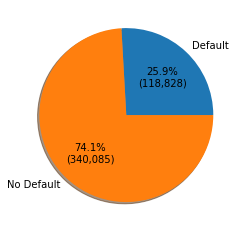

In [32]:
plt.pie(default_count["count"], labels=["Default", "No Default"], autopct=my_fmt, shadow=True)
plt.show()

- There's more no default data than there is default data
- Data balancing techniques may be required
- This is a downsampled version as the No Default data is scaled down 20x
- Real imbalance is approximately 98% No Default and 2% Default

# The Testing and Training Data

In [33]:
train_df = spark.read.csv(config["TRAIN_PATH"], header=True, inferSchema=True)
test_df = spark.read.csv(config["TEST_PATH"], header=True, inferSchema=True)

In [34]:
train_df.head(5)

[Row(customer_ID='0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a', S_2=datetime.datetime(2017, 3, 9, 0, 0), P_2=0.9384687191272548, D_39=0.0017333390041739, B_1=0.0087244509498605, B_2=1.0068382339663076, R_1=0.0092277222786689, S_3=0.1240351558143743, D_41=0.0087711319938824, B_3=0.0047092406313857, D_42=None, D_43=None, D_44=0.000630134804911503, B_4=0.0809863324662527, D_45=0.708906305121159, B_5=0.1706002293387026, R_2=0.0062040314303209, D_46=0.3585865793715965, D_47=0.525351040810055, D_48=0.255736073902975, D_49=None, B_6=0.0639022133803909, B_7=0.0594157330614109, B_8=0.006465576798311, D_50=0.1486979558199995, D_51=1.3358557940752642, B_9=0.0082067391252636, R_3=0.0014225021561254, D_52=0.2073338786110817, P_3=0.7364627260945562, B_10=0.0962188066642168, D_53=None, S_5=0.0233811220509184, B_11=0.0027680616648439, S_6=0.0083216461012018, D_54=1.0015189798143298, R_4=0.0082984353659013, S_7=0.1613448213392926, B_12=0.1482660660500143, S_8=0.9229980580065352, D_

In [35]:
test_df.head(5)

[Row(customer_ID='00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7', S_2=datetime.datetime(2019, 2, 19, 0, 0), P_2=0.631315348870127, D_39=0.0019117764764965, B_1=0.0107280865415314, B_2=0.8144968588558597, R_1=0.0075468996994418, S_3=0.1686508406762685, D_41=0.0099714525530773, B_3=0.0023469930565875, D_42=0.1131888918343083, D_43=None, D_44=0.0075839407750031, B_4=0.1164022289247906, D_45=0.0044825219725134, B_5=0.0095167747593996, R_2=0.0051778780931715, D_46=None, D_47=0.4743833427304856, D_48=0.626466914148911, D_49=None, B_6=0.1745910796093573, B_7=1.2506765348178908, B_8=1.003925464255982, D_50=None, D_51=0.0087178835533091, B_9=0.0010129373793993, R_3=0.1035897430477255, D_52=0.119043469590424, P_3=None, B_10=-0.0029186420127821, D_53=None, S_5=0.0027711123379222, B_11=0.004416113504079, S_6=1.006874529728068, D_54=1.00506876306948, R_4=0.0028096914463902, S_7=0.1055866024109917, B_12=0.1191980794718266, S_8=0.3216764047819389, D_55=0.114563534989097, D_56=None,

## Print Time Frame for Train and Test Data

In [36]:
print('Training Data Time Frame', train_df.agg({"S_2":"min"}).collect(), train_df.agg({"S_2":"max"}).collect(), train_df["S_2"].isNull())

Training Data Time Frame [Row(min(S_2)=datetime.datetime(2017, 3, 1, 0, 0))] [Row(max(S_2)=datetime.datetime(2018, 3, 31, 0, 0))] Column<'(S_2 IS NULL)'>


In [37]:
print('Testing Data Time Frame', test_df.agg({"S_2":"min"}).collect(), test_df.agg({"S_2":"max"}).collect(), test_df["S_2"].isNull())

Testing Data Time Frame [Row(min(S_2)=datetime.datetime(2018, 4, 1, 0, 0))] [Row(max(S_2)=datetime.datetime(2019, 10, 31, 0, 0))] Column<'(S_2 IS NULL)'>


- The timeframe for the training data is from March 1, 2017 to March 31, 2018
- The timeframe for the testing data is April 1, 2018 to October 31, 2019
- Two separate timeframes

## Count Null Values in each Column

In [49]:
train_df.select([F.sum(F.col(c).isNull().cast(T.IntegerType())).alias(c) for c in train_df.columns]).show()

+-----------+---+-----+----+---+----+---+-------+----+----+-------+-------+------+---+----+---+---+-------+----+------+-------+---+---+-----+-------+----+---+---+-----+------+----+-------+---+----+---+----+---+-------+----+---+------+-------+-----+---+----+-------+----+------+----+------+----+----+------+----+------+----+----+-------+----+----+-------+----+------+----+---+----+----+------+----+-----+----+-----+----+----+-------+---+-----+----+-------+----+---+-------+----+----+------+-----+---+-------+----+-----+----+----+----+-----+-------+----+----+----+----+------+----+----+-----+----+-------+----+----+----+-------+----+----+-------+----+----+----+----+----+----+----+----+-----+----+----+------+----+----+----+----+----+----+-----+----+-----+-----+----+-----+------+------+-------+-------+------+----+----+-------+------+----+-------+-----+-------+-------+-------+-----+----+-------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+-

In [50]:
test_df.select([F.sum(F.col(c).isNull().cast(T.IntegerType())).alias(c) for c in test_df.columns]).show()

+-----------+---+-----+----+---+----+---+-------+----+----+--------+-------+------+---+----+---+---+-------+----+-------+--------+----+---+------+-------+----+---+---+-----+------+----+-------+---+----+---+----+---+-------+----+---+------+-------+-----+---+----+-------+----+------+----+-------+-----+----+-------+----+------+----+----+-------+----+----+--------+----+------+----+---+----+----+------+----+------+----+-----+----+----+--------+---+-----+----+--------+----+---+-------+-----+----+------+-----+---+--------+----+-----+----+----+----+-----+-------+-----+----+----+----+------+----+----+-----+----+-------+----+----+----+--------+----+----+--------+----+----+----+----+----+----+----+----+-----+----+----+------+----+----+----+----+----+----+-----+----+-----+-----+----+-----+-----+-----+-------+--------+-----+----+----+-------+------+----+--------+-----+--------+--------+--------+-----+----+-------+------+------+------+------+------+------+------+------+------+------+------+------+--

- There are a lot of missing values in many of the columns
- Don't drop any columns
- Don't drop any rows
- Decision-Tree Models can deal with missing values
- NN Models need imputed values